# Permeation method for hydrogen transport properties in molten salt

In this notebook we'll describe the method employed to estimate the diffusivity and solubility of hydrogen in molten salt using a permeation rig.

The principle of the measurement is to have hydrogen diffusing through a membrane (here a salt, with a negligible metal membrane). The upstream pressure is kept constant and the downstream volume will experience a pressure rise. The steady state pressure rise then gives information on the salt permeability and the time-lag (detailed below) gives an insight on the diffusivity. The ratio of the permeability and diffusivity yields the solubility.

Note: having a closed downstream volume slightly differs from Fukada's experiment on FLiNaK (2006) where the authors swept the downstream gas at a constant rate.

The experimental pressure rise will be mimicked by an analytical solution and we will then quantify the error propagation.

## Generating the data
Let us first find the salt properties in the literature using HTM. We will use the Fukada 2006 paper.

In [1]:
import h_transport_materials as htm

ureg = htm.ureg
ureg.setup_matplotlib()

D_flinak = htm.diffusivities.filter(author="fukada", year=2006, material="flinak")[0]
K_flinak = htm.solubilities.filter(author="fukada", year=2006, material="flinak")[0]
D_flibe = htm.diffusivities.filter(material=htm.FLIBE, author='calderoni')[0]
K_flibe = htm.solubilities.filter(material=htm.FLIBE, author='calderoni')[0]

print("Diffusivity:")
print(D_flinak)
print("Solubility:")
print(K_flinak)

Diffusivity:

        Author: Fukada
        Material: flinak
        Year: 2006
        Isotope: H
        Pre-exponential factor: 3.70×10⁻⁶ m²/s
        Activation energy: 4.50×10⁻¹ eV/particle
        
Solubility:

        Author: Fukada
        Material: flinak
        Year: 2006
        Isotope: H
        Pre-exponential factor: 2.03×10¹⁷ particle/Pa/m³
        Activation energy: -3.72e-01 eV/particle
        


The experimental parameters from the design of HYPERION 6/16/2023

<img width="500" alt="image" src="https://github.com/RemDelaporteMathurin/hyperion/assets/40028739/7772f7ec-649a-4a0b-8e58-9cf053cbdbe2">

In [2]:
import numpy as np

height = 3.04 * ureg.inch
radius = 3.07/2 * ureg.inch
T = (273 + 700) * ureg.K  # temperature
V_down = (np.pi * radius**2 * height).to(ureg.m**3) # downstream volume
A = (np.pi * radius**2).to(ureg.m**2)  # gas/salt interface surface area 
P_up = 101325 * ureg.Pa  # upstream pressure
L = (0.31*ureg.inch).to(ureg.m)  # salt thickness

# estimate properties at operating temperature
D_flinak = D_flinak.value(T)
K_flinak = K_flinak.value(T).to(ureg.mol * ureg.m**(-3) * ureg.Pa**-1)
D_flibe = D_flibe.value(T)
K_flibe = K_flibe.value(T).to(ureg.mol * ureg.m**(-3) * ureg.Pa**-1)

permeability = D_flinak * K_flinak

We can now compute the transient analytical solution describing the downstream pressure rise.

$$P_\mathrm{down}(t) = R_g \ T \frac{A}{L \ V_\mathrm{down}} \ \Phi \ P_\mathrm{up} \left[t - \frac{L^2}{6 \ D} - \frac{2 \ L^2}{\pi^2 D} \sum_{n=1}^\infty \frac{(-1)^{n+1}}{n^2} \exp{\left( -\frac{D \ n^2 \pi^2}{L^2} t \right)}\right] $$

where $P_\mathrm{up}$ is the upstream pressure, $T$ is the temperature, $V$ is the downstream volume, $L$ is the thickness of salt, $R_g$ is the gas constant, and $A$ is the surface area of the gas/salt interface in the downstream chamber.

For more details, see:
- [Review of time lag permeation technique as a method for characterisation of porous media and membranes](https://link.springer.com/article/10.1007/BF01653631)
- [Hydrogen transport and trapping in ODS-EUROFER](https://doi.org/10.1016/j.fusengdes.2007.02.002)

In [3]:
#timelag = L**2 / (6 * D_flinak)
Rg = htm.Rg  # gas constant

# Analytical solution for transient downstream pressure rise
def downstream_pressure(t, P_up, diff, sol):

    tau = L**2 / (6 * diff)
    n_array = np.arange(1, 10000)[:, np.newaxis]
    sum_term = np.sum((-1) ** (n_array + 1)  / n_array**2 * np.exp(-diff * n_array**2 * np.pi**2 * t / L**2), axis=0)

    transient_term = 2 * L**2 / (np.pi**2 * diff) * sum_term
    return Rg * T / V_down * A / L * diff * sol * P_up * (t - tau + transient_term)

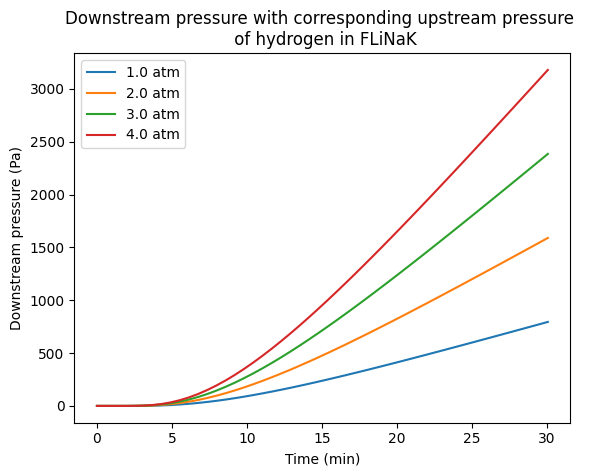

In [4]:
import matplotlib.pyplot as plt

tau_flinak = L**2 / (6 * D_flinak)
t = np.linspace(0, 3 * tau_flinak).to(ureg.min)
pressures = (np.linspace(1, 4, num=4) * htm.ureg.atm)
for P_up in pressures:
    plt.plot(t, downstream_pressure(t, P_up, D_flinak, K_flinak).to(ureg.Pa), label = f"{P_up:~P}")
#p_down = downstream_pressure(t, P_up).to(ureg.Pa)

#plt.plot(t, p_down)
plt.legend()
plt.xlabel(f"Time ({t.units:~})")
plt.ylabel(f"Downstream pressure (Pa)")
plt.title("Downstream pressure with corresponding upstream pressure \n of hydrogen in FLiNaK")
plt.show()


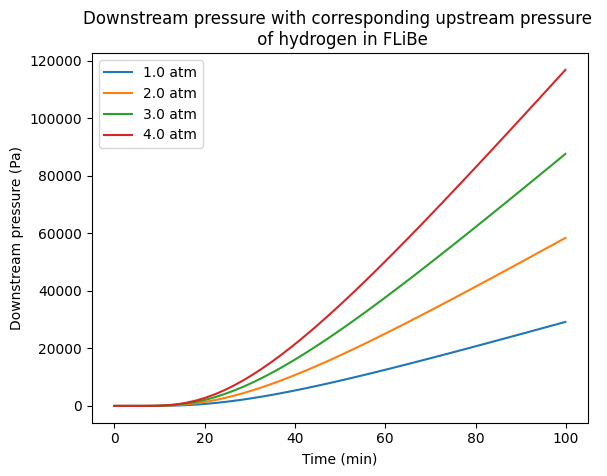

In [5]:
tau_flibe = L**2 / (6 * D_flibe)
t = np.linspace(0, 3 * tau_flibe).to(ureg.min)
pressures = (np.linspace(1, 4, num=4) * htm.ureg.atm)
for P_up in pressures:
    plt.plot(t, downstream_pressure(t, P_up, D_flibe, K_flibe).to(ureg.Pa), label = f"{P_up:~P}")

plt.legend()
plt.xlabel(f"Time ({t.units:~})")
plt.ylabel(f"Downstream pressure (Pa)")
plt.title("Downstream pressure with corresponding upstream pressure \n of hydrogen in FLiBe")
plt.show()